# Bike Sharing Prediction

 
##### <span style="color:red"> Predict the total number of Washington D.C. bicycle users on an hourly basis.</span>

 <img src="https://cdn.dribbble.com/users/320587/screenshots/1436586/gold-bike-asset-_dribbble_.gif" width="300" height="300" align="right" /> 
 
A bicycle-sharing system is a shared transport service in which bicycles are made available for public use to individuals during a short amount of time for a small fee. The uses of these services is highly influenced by seasonal and environmental conditions. In this notebook we will be evaluating how these conditions like humidity, windspeed, temperature, and the position of the sun directly affect the amount of bikes employed at a given time. With this information we will be predicting the total amount of bike users at each point throughout the day.

##### Task description:

- Training data: whole 2011 and first 3 quarters of 2012.
- Test data: 4th quarter of 2012.
- Target: total number of users (cnt)
- Error metric: R2 score (scikit-learn's default for regression).
- Features to use: at least the ones present in the data (except for cnt, casual, and registered).

### Importing libraries to be used:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from astral import LocationInfo
from astral.sun import sun
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# set random values to get similar result on multiple runs
np.random.seed=42
random_state=42

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

### Loading our dataset:

In [3]:
# Read file
df = pd.read_csv("data/hour.csv", parse_dates=["dteday"], index_col="instant")

df.head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


In [4]:
df.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [5]:
# renaming some columns

df = df.rename(columns={"dteday":"date", "weathersit":"weather", "cnt":"count", "hr":"hour", "hum":"humidity"})

df.head()

,date,hour,weather,temp,atemp,humidity,windspeed,casual,registered,count
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


## Exploratory Data Analysis

Here we will be exploring our dataset for inconsistencies, missing values, outliers, and plotting meaningful figures to gather insights on what might be relevant to our prediction or not.

In [6]:
# Checking for na values
df.isnull().sum()

date            0
hour            0
weather       100
temp           99
atemp         100
humidity      100
windspeed     100
casual          0
registered      0
count           0
dtype: int64

<AxesSubplot:ylabel='instant'>

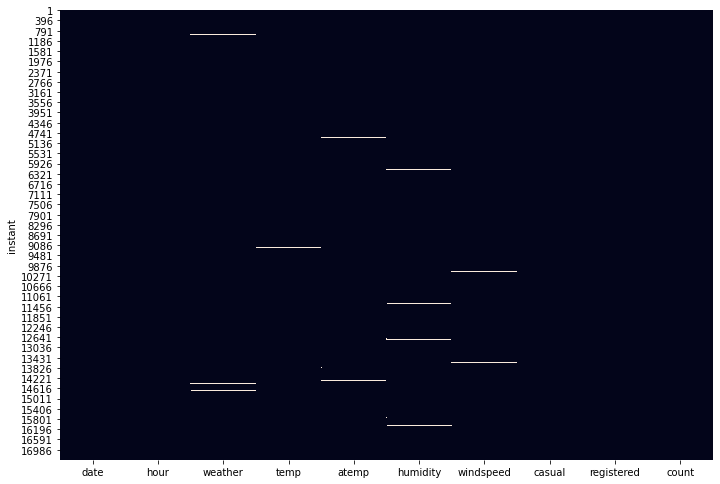

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(df.isnull(), cbar=False)

We can see the missing values are sparsely located. This is important because considering we are dealing with weather data and each value accounts for only an hour of the day, we can be almost certain that the weather in that hour is going to be the same as the hour before. This means we can just do a forward fill or a back fill and probably get very accurate results.  

<AxesSubplot:>

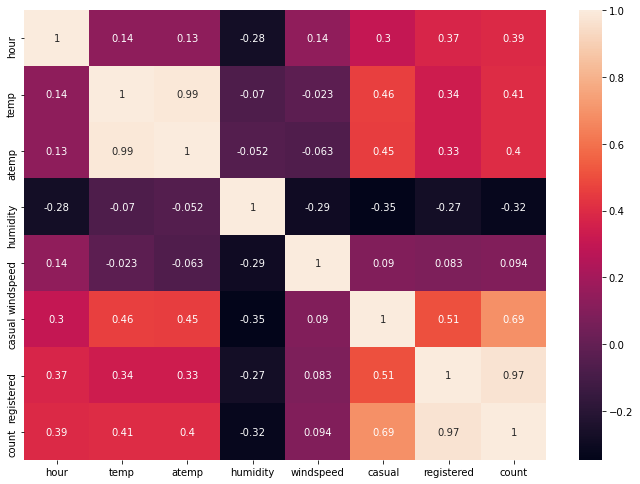

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(df.corr(), annot=True)

- atemp and temp seem to be very highly correlated.
- hour and temperature have a good correlation with our target variable.
- humidity has a significant negative correlation with total count, probably because of its relationship with weather condition.

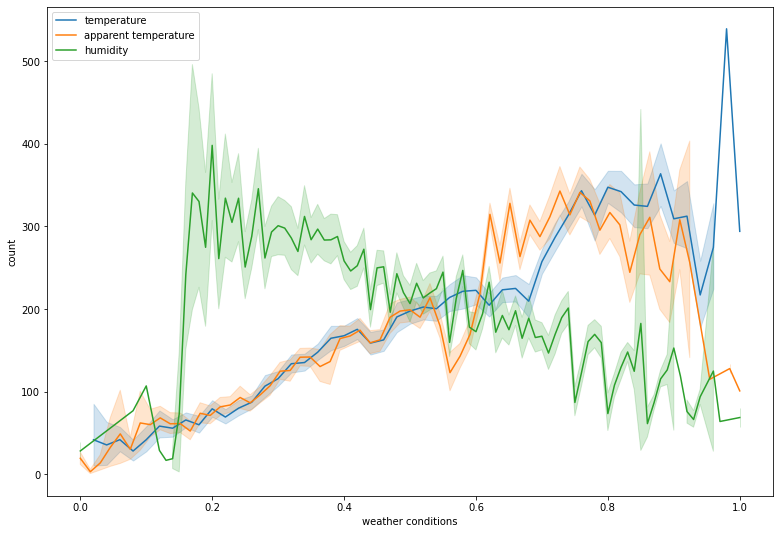

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 9)
fig1 = sns.lineplot(x="temp", y="count", data=df, ax=ax)
fig1 = sns.lineplot(x="atemp", y="count", data=df, ax=ax)
fig1 =sns.lineplot(x="humidity", y="count", data=df, ax=ax)
fig1.set_xlabel("weather conditions")
ax.legend(labels=["temperature", "apparent temperature","humidity"])
leg = ax.get_legend()

We can see here the negative correlation with humidity and the rising count of users with the increase in temperature we talked about before. Let's explore how this relates to the general weather condition as well.

In [10]:
df.weather.value_counts()

Clear, Few clouds, Partly cloudy, Partly cloudy                                            11345
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                4517
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     1414
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                     3
Name: weather, dtype: int64

(<AxesSubplot:xlabel='weather', ylabel='count'>,
 <AxesSubplot:xlabel='weather', ylabel='humidity'>)

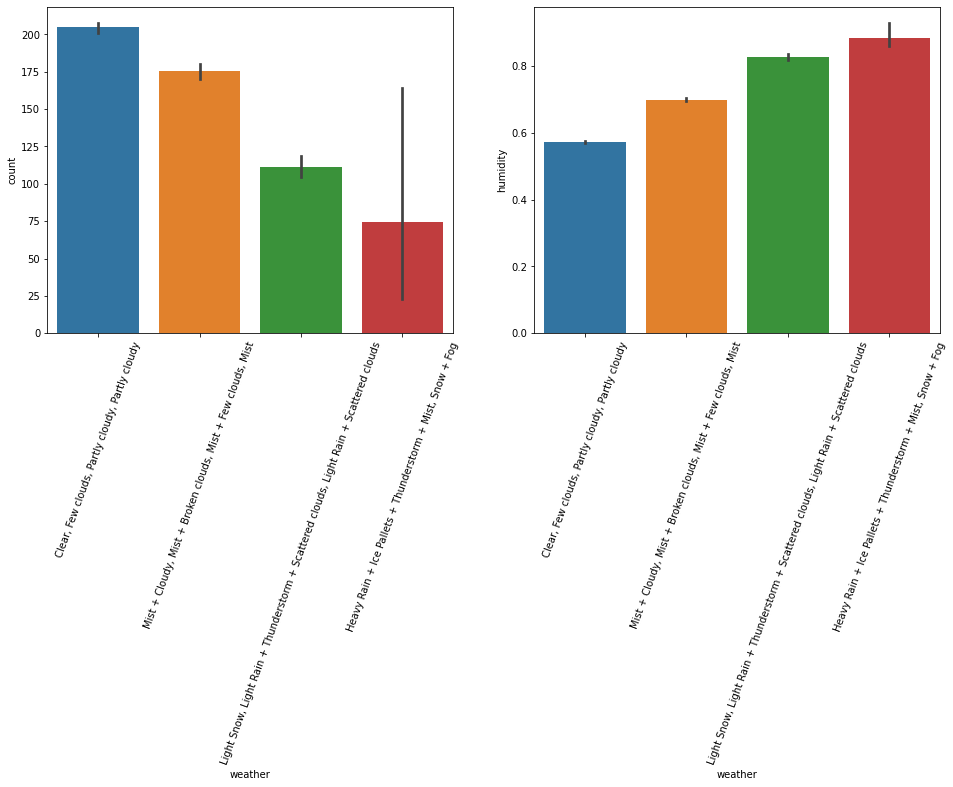

In [11]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)
fig1 = sns.barplot(x="weather", y="count", data=df, ax=ax[0])
fig2 = sns.barplot(x="weather", y="humidity", data=df, ax=ax[1])
weather_labels = df.weather.unique()[pd.notnull(df.weather.unique())]
fig1.set_xticklabels(rotation=70, labels=weather_labels)
fig2.set_xticklabels(rotation=70, labels=weather_labels)
fig1, fig2

- We can see there is a clear descent when looking at the distributions of total bikes being used under each weather condition. Maybe we can apply an ordinal encoding going from most preferable to harshest weather.
- The decline in users according to the weather seems familiar to the decline we saw earlier in humidity, so we plot weather with humidity as well and we can see there is some kind of correlation.

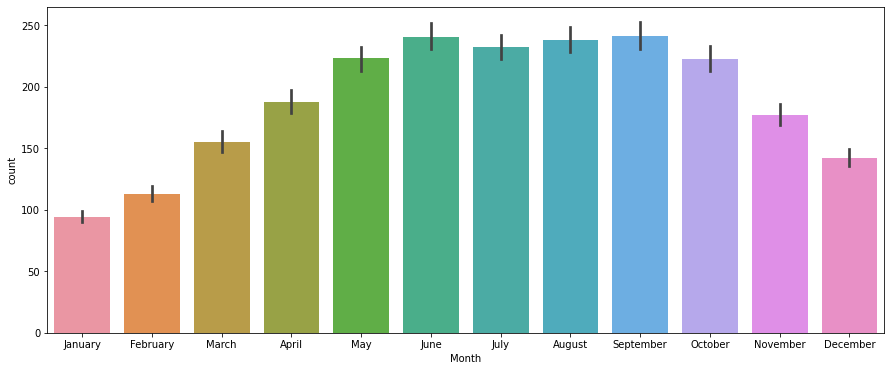

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
fig = sns.barplot(x=df["date"].dt.month, y="count", data=df)
fig.set_xticklabels(labels=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
fig.set_xlabel("Month")
plt.show()

In this figure we can see how the total count of users gradually increases as we go into the spring and summer months, with winter months like January showing the lowest point for all users. We can definitely create a seasonal feature in our pipeline to reflect this.

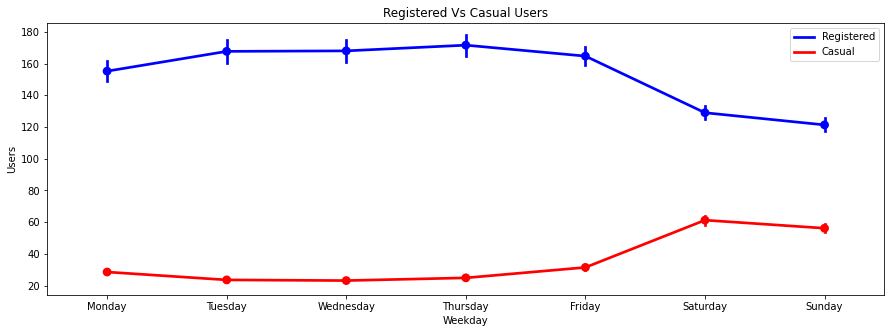

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
fig = sns.pointplot(x=df["date"].dt.weekday, y="registered", data=df, color="blue")
fig = sns.pointplot(x=df["date"].dt.weekday, y="casual", data=df, color="red")
fig.set_xlabel("Weekday")
fig.set_ylabel("Users")
fig.set_xticklabels(labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax.legend(labels=["Registered", "Casual"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
ax.set_title("Registered Vs Casual Users")
plt.show()

plt.show()

The amount of registered users is still higher than casual users even over the weekend. This means the amount of registered users that don't only use the bikes for work but for transport during the weekend is significant.

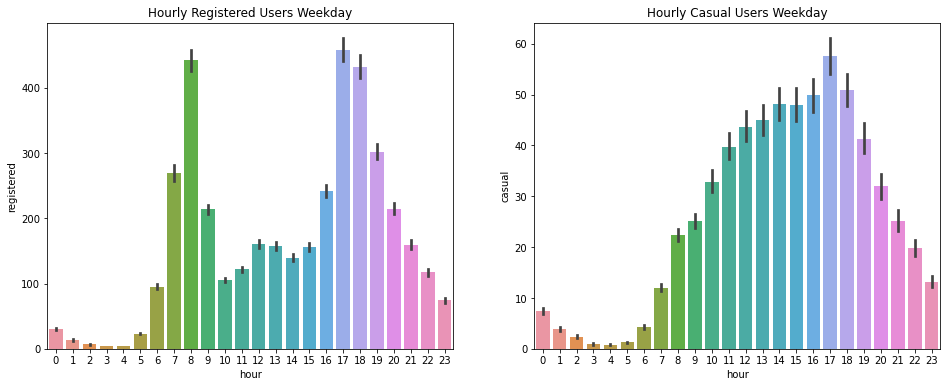

In [21]:
weekend = df[df["date"].dt.weekday>4]
weekday = df[df["date"].dt.weekday<5]

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)

fig = sns.barplot(x="hour", y="registered", data=weekday, ax=ax[0]).set_title("Hourly Registered Users Weekday")
fig2 = sns.barplot(x="hour", y="casual", data=weekday, ax=ax[1]).set_title("Hourly Casual Users Weekday")

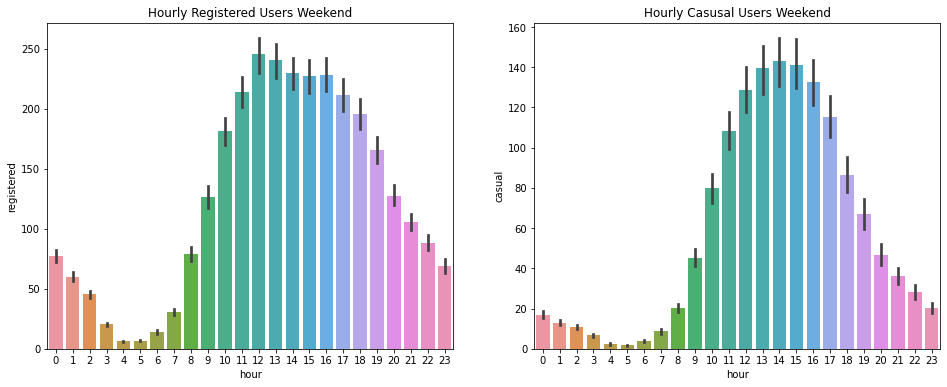

In [24]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)

fig3 = sns.barplot(x="hour", y="registered", data=weekend, ax=ax[0]).set_title("Hourly Registered Users Weekend")
fig4 = sns.barplot(x="hour", y="casual", data=weekend, ax=ax[1]).set_title("Hourly Casusal Users Weekend")

Looking at these charts it might be helpful to create a rush hour feature to describe the trend happening with registered users, seeing as they account for the majority of users. If we look closely we can notice that the amount of users over the weekend and the amount of casual users is drastically lower than the amount of registered users over the week.

## Outlier Analysis

In [25]:
def extract_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25) 
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return df_out

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25) 
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

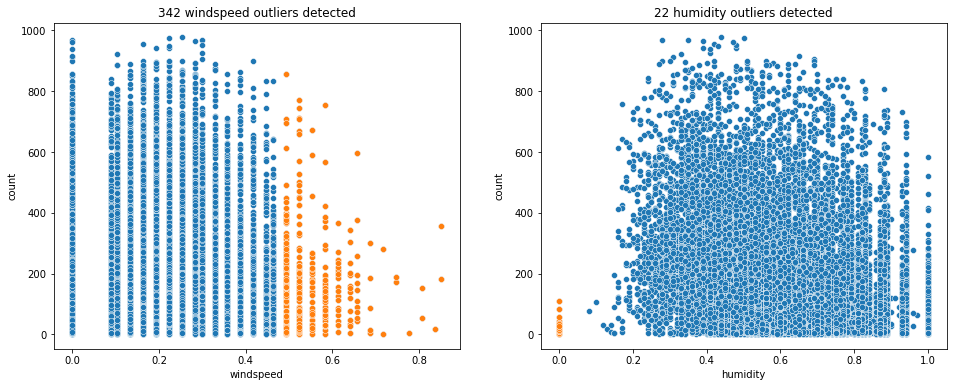

In [31]:
wind_out = extract_outlier(df, "windspeed")
hum_out = extract_outlier(df, "humidity")
temp_out = extract_outlier(df, "temp")
atemp_out = extract_outlier(df, "atemp")

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)

fig1 = sns.scatterplot(x="windspeed", y="count", data=df, ax=ax[0])\
          .set_title("{} windspeed outliers detected".format(len(wind_out)))
fig1 = sns.scatterplot(x="windspeed", y="count", data=wind_out, ax=ax[0])

fig2 = sns.scatterplot(x="humidity", y="count", data=df, ax=ax[1])\
          .set_title("{} humidity outliers detected".format(len(hum_out)))
fig2 = sns.scatterplot(x="humidity", y="count", data=hum_out, ax=ax[1])

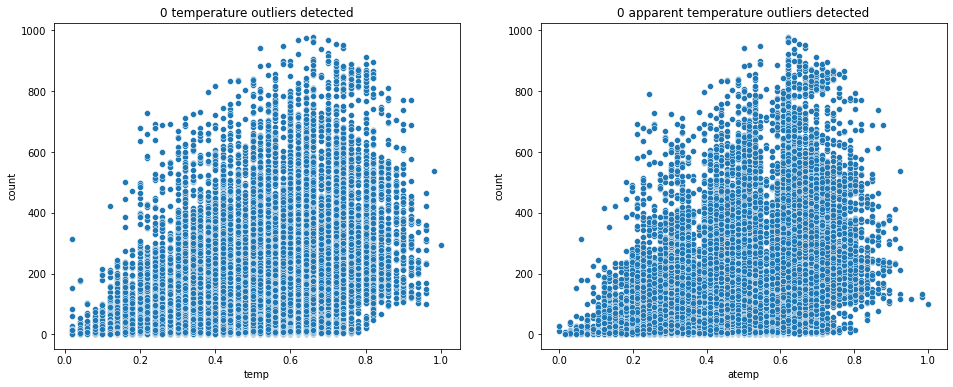

In [32]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)

fig3 = sns.scatterplot(x="temp", y="count", data=df, ax=ax[0])\
          .set_title("{} temperature outliers detected".format(len(temp_out)))
fig3 = sns.scatterplot(x="temp", y="count", data=temp_out, ax=ax[0])

fig4 = sns.scatterplot(x="atemp", y="count", data=df, ax=ax[1])\
          .set_title("{} apparent temperature outliers detected".format(len(atemp_out)))
fig4 = sns.scatterplot(x="atemp", y="count", data=atemp_out, ax=ax[1])

We can see here there are no outliers for temperature and apparent temperature. For windspeed we have 342 outliers, but we thinks it's best to keep these values since they seem to contain important information. When the windspeed gets too high we can see a significant decline in the count of bicycle users which might be crucial to our analysis. 

Looking at humidity we see we have 22 outliers at 0 humidity. After a bit of research we found from the chicago tribune that "the concept of zero percent relative humidity — air devoid of water vapor — is intriguing, but given Earth's climate and weather conditions, it's impossible"(https://www.chicagotribune.com/news/ct-xpm-2011-12-16-ct-wea-1216-asktom-20111216-story.html). So we can definitely remove these outliers from our data.

We can probably create a new feature called inclement weather with this information, by taking all rows with a humidity greater than 0.8 and a windspeed greater than 0.5.

## Feature Engineering

Let's define the functions we are going to use in our pipeline to extract some new features.

In [33]:
# Extracte date features
def extract_date_features(series):
    df = pd.DataFrame({"year": series.dt.year,
                       "month": series.dt.month,
                       "weekday": series.dt.weekday,
                       "day": series.dt.day,
                       "season": (series.dt.month%12 + 3)//3})
    return df

# Extract Weekends
def extract_weekend(series):
    weekend = list(map(lambda x: 1 if x>4 else 0, series.dt.weekday))
    
    return pd.DataFrame({"weekend": weekend})

# Extract Rush-hour
def extract_rush_hour(df):
    rush_hour = list(map(lambda x, y: 1 if ((x>4) & (y in [12,13,14,15]) | 
                                            (x<5) & (y in [6,7,8,16,17,18,19])) 
                                        else 0, 
                                        df["date"].dt.weekday, 
                                        df["hour"])
                    )
    
    return pd.DataFrame({"rush_hour": rush_hour})

In [34]:
# Helper library to extract daylight
def get_loc_info(location="Washington"):
    # get latitude and longitude
    geolocator = Nominatim(user_agent="pythonGA") # here user_agent is to limit the number of requ
    location = geolocator.geocode(location)
    
    # find the time zone from location
    obj = TimezoneFinder() 
    timezone = obj.timezone_at(lng=location.longitude, lat=location.latitude)
    
    # get sun movment from location and time zone.
    # Location Info takes 5 arguments.
    # 1. City
    # 2. Region
    # 3. Timezone
    # 4. Latitude
    # 5. Longitude
    return LocationInfo(location, "US, East Cost", timezone, location.latitude, location.longitude)

# city will be used to get sunrise and sunset values for Washington.
city = get_loc_info()

# Extract daylight
def get_day_light(df):
    sunrise = list(map(lambda x: sun(city.observer, date=x, tzinfo=city.timezone)["sunrise"].hour, df["date"]))
    sunset = list(map(lambda x: sun(city.observer, date=x, tzinfo=city.timezone)["sunset"].hour, df["date"]))
    daylight = list(map(lambda x, sunrise, sunset: 1 if (x > sunrise) & (x < sunset) 
                                        else 0,
                                     df["hour"], sunrise, sunset))
    return pd.DataFrame({"daylight": daylight})

In [35]:
# Extract Holiday
def get_holiday(series):
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=series.min(), end=series.max())
    holiday = series.isin(holidays).astype(int)
    
    return pd.DataFrame({"holiday": holiday})


# Encoding weather with giving higher score for clear skies and lower score for heavy rain and snow.
# The Reason behind this is to test a hypothesis that people are more likely to ride bike during comfortable weather.
def encode_weather(df):
    categorical_encode = {"weather": {"Clear, Few clouds, Partly cloudy, Partly cloudy": 4,
                                     "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist": 3,
                                     "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds": 2,
                                     "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog": 1}}
    
    return df.replace(categorical_encode)

In [36]:
# We added this feature to see if severe weather have effect on Bike riders.
def extract_inclement_weather(df):
    inclement_weather = map(lambda x, y: 1 if ((x>0.5) & (y>0.8)) else 0, df["windspeed"], df["humidity"])
    return pd.DataFrame({"inclement_weather": inclement_weather})

### Putting it all together

In [37]:
preprocessing = ColumnTransformer([
    ("date_encoder", FunctionTransformer(extract_date_features), "date"), #output - year, month, weekday, day, season
    ("weekend_extractor", FunctionTransformer(extract_weekend), "date"), #output - weekend
    
    ("rush_hour_extractor", FunctionTransformer(extract_rush_hour), ["date", "hour"]), #output - rush_hour
    
    ("weather_encoder", Pipeline([
        ("weather_imputer", FunctionTransformer(lambda x: x.ffill())),
        ("weather_encode_values", FunctionTransformer(encode_weather)),
    ]), ["weather"]), #output - weather
    
    
    ("conditions_encoder", FunctionTransformer(lambda series: series.ffill()), 
                                                 ["humidity", 
                                                  "atemp", 
                                                  "temp", 
                                                  "windspeed"]), #output - humidity, atemp, temp, windseed
    
    ("day_light_extractor", FunctionTransformer(get_day_light), ["date", "hour"]), #output - daylight
    ("holiday_extractor", FunctionTransformer(get_holiday), "date"), #output - holiday
    ("inclement_weather_exctractor", FunctionTransformer(extract_inclement_weather), ["windspeed", "humidity"]), #output - inclement_weather
    ("hour", "passthrough", ["hour"]) 
])

In [38]:
X = df.drop(columns=["count", "registered", "casual"])

processed = preprocessing.fit_transform(X)

In [39]:
# Get our dataframe from the preprocessed data.
columns = ["year", "month", "weekday", "day", "season", "weekend", "rush_hour", "weather",
           "humidity", "atemp", "temp", "windspeed", "daylight", "holiday", "inclement_weather", "hour"]

data_processed = pd.DataFrame(processed, columns = columns, index=df["date"])

data_processed.head()

,year,month,weekday,day,season,weekend,rush_hour,weather,humidity,atemp,temp,windspeed,daylight,holiday,inclement_weather,hour
date,,,,,,,,,,,,,,,,
2011-01-01,2011.0,1.0,5.0,1.0,1.0,1.0,0.0,4.0,0.81,0.2879,0.24,0.0,0.0,0.0,0.0,0.0
2011-01-01,2011.0,1.0,5.0,1.0,1.0,1.0,0.0,4.0,0.80,0.2727,0.22,0.0,0.0,0.0,0.0,1.0
2011-01-01,2011.0,1.0,5.0,1.0,1.0,1.0,0.0,4.0,0.80,0.2727,0.22,0.0,0.0,0.0,0.0,2.0
2011-01-01,2011.0,1.0,5.0,1.0,1.0,1.0,0.0,4.0,0.75,0.2879,0.24,0.0,0.0,0.0,0.0,3.0
2011-01-01,2011.0,1.0,5.0,1.0,1.0,1.0,0.0,4.0,0.75,0.2879,0.24,0.0,0.0,0.0,0.0,4.0


# Modeling (Machine Learning)

In this section we will be examining the importance of each of our features and testing multiple machine learning algorithms and tuning their parameters to determine what will be the best model for our prediction.

### Test Data Split

Before moving on to modeling, let's split our dataset into train and test. We will be testing our models using this test data.

In [40]:
date_split = pd.to_datetime("2012-09-01")
train_data = data_processed[data_processed.index < date_split]
train_target = df[df["date"] < date_split][["date", "count"]]

# this will be kept for testing our models.
test_data = data_processed[data_processed.index >= date_split]
test_target = df[df["date"] >= date_split][["date", "count"]]

print("Training data size: {}".format(train_data.shape))
print("Training target size: {}".format(train_target.shape))
print("Test data size: {}".format(test_data.shape))
print("Test target size: {}".format(test_target.shape))

Training data size: (14491, 16)
Training target size: (14491, 2)
Test data size: (2888, 16)
Test target size: (2888, 2)


### Feature Selection

**Feature selection** is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model. We might also see which features combinations are better in predicting our target variable.

We will be using tow different methods **F-test statistics and mutual information gain**

As F-test captures only linear dependency, on the other hand, mutual information can capture any kind of dependency between variables.

In [41]:
# Lets get our train and target data
X = train_data
y = train_target["count"]

Text(0.5, 1.0, 'Univariate regression Scoring of features')

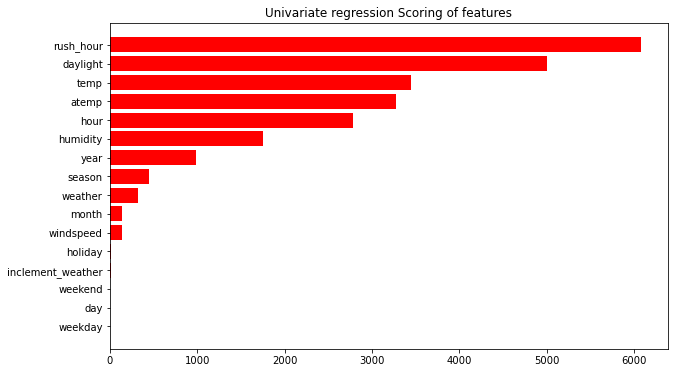

In [65]:
# Select K best features according to the two different methods
reg_selector = SelectKBest(score_func=f_regression).fit(X,y)  # using Univariate Linear regression
ig_selector = SelectKBest(score_func=mutual_info_regression).fit(X,y)  # using Information Gain

# Get the indices sorted by most important to least important
indices_reg = np.argsort(reg_selector.scores_)[::-1]
indices_ig = np.argsort(ig_selector.scores_)[::-1]

# Features and their score on each method
reg_features = []
for i in range(len(X.columns)):
    reg_features.append(X.columns[indices_reg[i]])
    
ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices_ig[i]])
    
# Plotting
fig, axes = plt.subplots(figsize=(10, 6))

# reg scores
axes.invert_yaxis()
axes.barh(reg_features, reg_selector.scores_[indices_reg[range(len(X.columns))]], color='r', align='center')
axes.set_title("Univariate regression Scoring of features")

Text(0.5, 1.0, 'Information Gain Scoring of features')

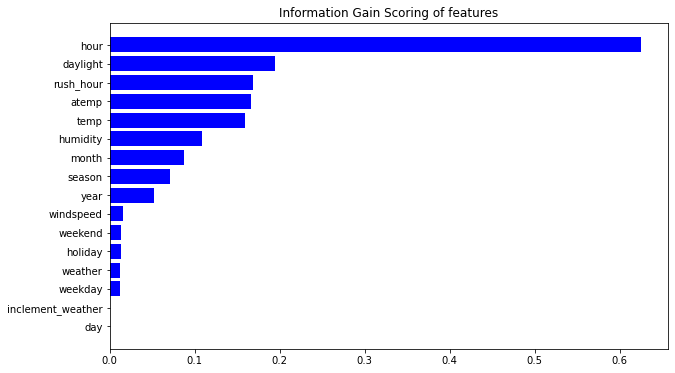

In [66]:
fig, axes = plt.subplots(figsize=(10, 6))

# information-gain scores
axes.invert_yaxis()
axes.barh(ig_features, ig_selector.scores_[indices_ig[range(len(X.columns))]], color='b', align='center')
axes.set_title("Information Gain Scoring of features")

As seen from the two different plots, we have different feature imortance plots. When using F-test, we can see that the most important features are related with the condition of the day and condition of traffic. It is obvious that people use bikes during the day time which explains why we have daylight as the most important one. Also during rush-hour more people are riding bikes either to go to work and thier homes.

On the other hand, looking at information gain, we have **hour** as the most important feature. This could be expained by the hypothesis that most of the our features are different multiple or degrees of the hour.

Now it's time to test this features on some models.

In [68]:
print(X.index.min())
print(X.index.max())

2011-01-01 00:00:00
2012-08-31 00:00:00


Using our train data, let's split the data again for validation purpose

In [69]:
def train_test_split(X, y, date_split):
    # splitting data
    X_train = X[X.index < date_split]
    X_test = X[X.index >= date_split]
    y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
    y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()

    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

# split time
date_split = pd.to_datetime("2012-07-01")

In [70]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, date_split)

X_train: (13003, 16)
X_test: (1488, 16)
y_train: (13003,)
y_test: (1488,)


### Simple Models

In [71]:
linear_model = LinearRegression()
lasso_model = Lasso()
ridge_model = Ridge()
elastic_model = ElasticNet()
tree_model = DecisionTreeRegressor()

methods = {
    "reg": reg_features,
    "ig": ig_features
}

comparison = []
for name, sorted_features in methods.items():
    features_used = 0
    for i, feature in enumerate(sorted_features):

        # training on a bigger subset of features as we loop through both feature selection methods
        # as i increases, a new feature is added to the training dataset
        # since the features were sorted in descending order of score, each added feature will add less value to our prediction
        X_train_subset = X_train[sorted_features[: i+1]]
        X_test_subset = X_test[sorted_features[: i+1]]

        # train
        linear_model.fit(X_train_subset, y_train)
        lasso_model.fit(X_train_subset, y_train)
        ridge_model.fit(X_train_subset, y_train)
        elastic_model.fit(X_train_subset, y_train)
        tree_model.fit(X_train_subset, y_train)

        # predict
        linear_reg_pred = linear_model.predict(X_test_subset)
        lasso_pred = lasso_model.predict(X_test_subset)
        ridge_pred = ridge_model.predict(X_test_subset)
        elastic_pred = elastic_model.predict(X_test_subset)
        tree_pred = tree_model.predict(X_test_subset)
        
        # calculate accuracy
        linear_reg_score = r2_score(y_test, linear_reg_pred)
        lasso_score = r2_score(y_test, lasso_pred)
        ridge_score = r2_score(y_test, ridge_pred)
        elastic_score = r2_score(y_test, elastic_pred)
        tree_score = r2_score(y_test, tree_pred)

        # increase counter to see how many features we have trained with
        features_used += 1
        dict_sorted = {
            "features": features_used,
            "linear_reg_r2_score": linear_reg_score,
            "lasso_r2_score": lasso_score,
            "ridge_r2_score": ridge_score,
            "elastic_r2_score": elastic_score,
            "tree_r2_score": tree_score,
            "type": name
        }
        comparison.append(dict_sorted)

Text(0.5, 1.0, 'Real Vs Predicted Count')

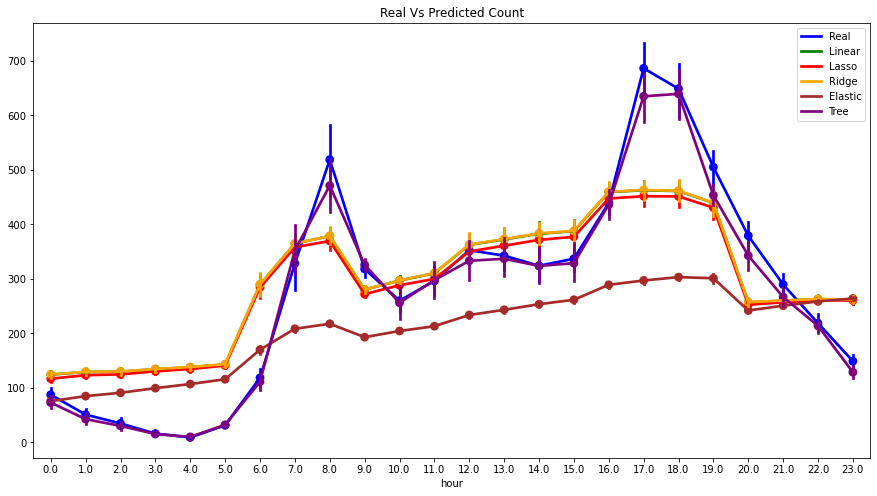

In [72]:
# put everything together in a dataframe
comparision_df = pd.DataFrame(comparison).pivot_table(index="features", columns="type")


# Plot Real Vs Predicted
hour=X_test.hour

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.pointplot(ax=ax, x=hour, y=y_test, color='blue')
sns.pointplot(ax=ax, x=hour, y=linear_reg_pred, color='green')
sns.pointplot(ax=ax, x=hour, y=lasso_pred, color='red')
sns.pointplot(ax=ax, x=hour, y=ridge_pred, color='orange')
sns.pointplot(ax=ax, x=hour, y=elastic_pred, color='brown')
sns.pointplot(ax=ax, x=hour, y=tree_pred, color='purple')


ax.legend(labels=["Real", "Linear","Lasso","Ridge", "Elastic", "Tree"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('green')
leg.legendHandles[2].set_color('red')
leg.legendHandles[3].set_color('orange')
leg.legendHandles[4].set_color('brown')
leg.legendHandles[5].set_color('purple')
ax.set_title("Real Vs Predicted Count")

In [73]:
plt.show()

In [74]:
# Looking at the different model scores
comparision_df

elastic_r2_score           lasso_r2_score            \
type                   ig       reg             ig       reg   
features                                                       
1               -0.052906 -0.132045      -0.051721  0.096567   
2                0.065401 -0.012710       0.232140  0.276923   
3                0.150713  0.013202       0.392314  0.472749   
4                0.166266  0.029227       0.543642  0.472749   
5                0.184588  0.184588       0.557732  0.557843   
6                0.187349  0.187349       0.559737  0.559841   
7                0.209735  0.243380       0.560414  0.621984   
8                0.222345  0.283462       0.559540  0.624650   
9                0.292392  0.286418       0.627190  0.620313   
10               0.292386  0.294967       0.627190  0.622308   
11               0.292236  0.294962       0.625293  0.622308   
12               0.292243  0.294970       0.625293  0.622308   
13               0.294907  0.294970       0.621036  0.622308   
14               0.294040  0.294906       0.620491  0.621037   
15               0.294040  0.295361       0.620491  0.620426   
16               0.294501  0.294499       0.619930  0.619931   

         linear_reg_r2_score           ridge_r2_score           tree_r2_score  \
type                      ig       reg             ig       reg            ig   
features                                                                        
1                  -0.051433  0.102156      -0.051433  0.102072      0.347122   
2                   0.237359  0.284473       0.237303  0.284392      0.439645   
3                   0.399324  0.492414       0.399256  0.492092      0.561752   
4                   0.563554  0.480678       0.563233  0.481834      0.666962   
5                   0.563671  0.563671       0.566027  0.566027      0.629839   
6                   0.561421  0.561421       0.566400  0.566400      0.611457   
7                   0.561519  0.619470       0.566524  0.621811      0.557067   
8                   0.560978  0.620980       0.566148  0.623565      0.549887   
9                   0.623367  0.618683       0.624855  0.620544      0.774955   
10                  0.624339  0.620591       0.625067  0.621612      0.749978   
11                  0.621038  0.621258       0.621924  0.621849      0.810905   
12                  0.621512  0.621620       0.622253  0.622072      0.854507   
13                  0.619029  0.622164       0.619625  0.622597      0.817557   
14                  0.619015  0.619493       0.619607  0.620078      0.833398   
15                  0.619479  0.618807       0.620060  0.619357      0.839723   
16                  0.618801  0.618801       0.619346  0.619346      0.847077   

                    
type           reg  
features            
1         0.102156  
2         0.300930  
3         0.510055  
4         0.459691  
5         0.631094  
6         0.609036  
7         0.747161  
8         0.774423  
9         0.763337  
10        0.767951  
11        0.737946  
12        0.762273  
13        0.762899  
14        0.803505  
15        0.844758  
16        0.834092

Looks like **Decision Tree** is performing best. When we look at the target and predicted values, the prediction with decision tree is way closer to the real count. But when we look at our linear models, they have a pick values around 9 features.

Also in defence of the linear models, we have different scales in our features and we can also add polynomial features to see the effect. After this, We will be doing cross validation with time series split.

In [75]:
tscv = TimeSeriesSplit(n_splits=10)

def cv_r2(model, X, y):
    r2_cv = cross_val_score(model, X, y, scoring="r2", cv=tscv)
    return r2_cv

In [76]:
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=tscv))
lasso = make_pipeline(RobustScaler(), LassoCV(cv=tscv))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(cv=tscv))

In [77]:
score = cv_r2(lasso, train_data, train_target["count"])
print("Lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(elasticnet, train_data, train_target["count"])
print("Elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(ridge, train_data, train_target["count"])
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso: 0.5809 (0.0673)

Elastic net: 0.5536 (0.0543)

Ridge: 0.5815 (0.0677)



### Adding Polynomial features to our pipeline.

In [78]:
ridge = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), RidgeCV(cv=tscv))
lasso = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), LassoCV(cv=tscv))
elasticnet = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), ElasticNetCV(cv=tscv))

In [79]:
score = cv_r2(lasso, train_data, train_target["count"])
print("Lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(elasticnet, train_data, train_target["count"])
print("Elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(ridge, train_data, train_target["count"])
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso: 0.6141 (0.1243)

Elastic net: 0.6289 (0.0853)

Ridge: 0.5273 (0.2954)



We were right, our linear models performed better with polynomial features. 

May be increasing our polynomial degree might give a better result.

In [80]:
ridge = make_pipeline(RobustScaler(), PolynomialFeatures(degree=3), RidgeCV(cv=tscv))
lasso = make_pipeline(RobustScaler(), PolynomialFeatures(degree=3), LassoCV(cv=tscv))
elasticnet = make_pipeline(RobustScaler(), PolynomialFeatures(degree=3), ElasticNetCV(cv=tscv))

In [81]:
score = cv_r2(lasso, train_data, train_target["count"])
print("Lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(elasticnet, train_data, train_target["count"])
print("Elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(ridge, train_data, train_target["count"])
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso: 0.5424 (0.3415)

Elastic net: 0.5989 (0.1052)

Ridge: 0.3806 (0.4790)



Ummm, increasing the polynomial degree didn't help at all. 

Now that we have seen our linear models why not try to see the score of more complex models. First, let's see the performance with simple training

Text(0.5, 1.0, 'Real Vs Predicted Count')

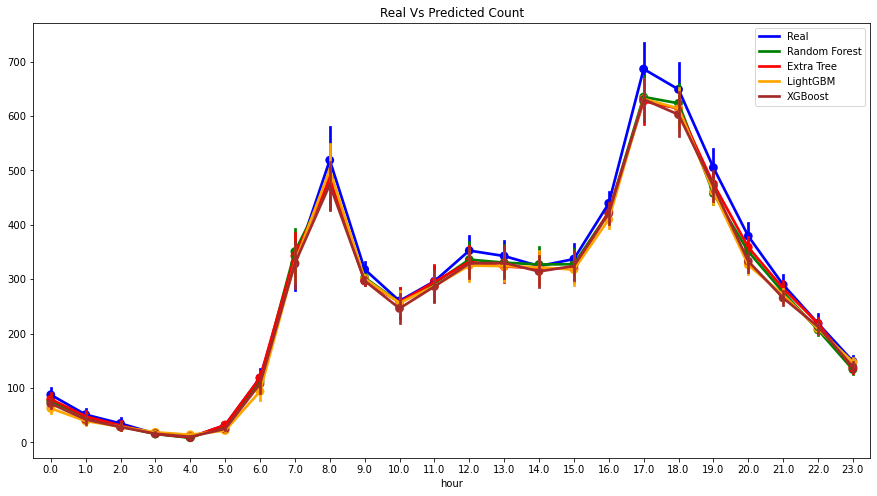

In [82]:
rndm_forest_model = RandomForestRegressor(random_state=random_state)
extra_tree_model = ExtraTreesRegressor()
lightgbm_model = LGBMRegressor()
xgb_model = XGBRegressor(objective="reg:squarederror") 


methods = {
    "reg": reg_features,
    "ig": ig_features
}

comparison = []
for name, sorted_features in methods.items():
    features_used = 0
    for i, feature in enumerate(sorted_features):

        # training on a bigger subset of features as we loop through both feature selection methods
        # as i increases, a new feature is added to the training dataset
        # since the features were sorted in descending order of score, each added feature will add less value to our prediction
        X_train_subset = X_train[sorted_features[: i+1]]
        X_test_subset = X_test[sorted_features[: i+1]]

        # train
        rndm_forest_model.fit(X_train_subset, y_train)
        extra_tree_model.fit(X_train_subset, y_train)
        lightgbm_model.fit(X_train_subset, y_train)
        xgb_model.fit(X_train_subset, y_train)

        # predict
        rndm_forest_pred = rndm_forest_model.predict(X_test_subset)
        extra_tree_pred = extra_tree_model.predict(X_test_subset)
        lightgbm_pred = lightgbm_model.predict(X_test_subset)
        xgb_pred = xgb_model.predict(X_test_subset)
        
        # calculate accuracy
        rndm_forest_score = r2_score(y_test, rndm_forest_pred)
        extra_tree_score = r2_score(y_test, extra_tree_pred)
        lightgbm_score = r2_score(y_test, lightgbm_pred)
        xgb_score = r2_score(y_test, xgb_pred)

        # increase counter to see how many features we have trained with
        features_used += 1
        dict_sorted = {
            "features": features_used,
            "rndm_forest_r2_score": rndm_forest_score,
            "extra_tree_r2_score": extra_tree_score,
            "lightgbm_r2_score": lightgbm_score,
            "xgb_r2_score": xgb_score,
            "type": name
        }
        comparison.append(dict_sorted)
        
# put everything together in a dataframe
comparision_df = pd.DataFrame(comparison).pivot_table(index="features", columns="type")


# Plot Real Vs Predicted
hour=X_test.hour

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.pointplot(ax=ax, x=hour, y=y_test, color='blue')
sns.pointplot(ax=ax, x=hour, y=rndm_forest_pred, color='green')
sns.pointplot(ax=ax, x=hour, y=extra_tree_pred, color='red')
sns.pointplot(ax=ax, x=hour, y=lightgbm_pred, color='orange')
sns.pointplot(ax=ax, x=hour, y=xgb_pred, color='brown')


ax.legend(labels=["Real", "Random Forest", "Extra Tree","LightGBM","XGBoost"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('green')
leg.legendHandles[2].set_color('red')
leg.legendHandles[3].set_color('orange')
leg.legendHandles[4].set_color('brown')
ax.set_title("Real Vs Predicted Count")

In [83]:
plt.show()

Amazing! As we can see from the plot, our models are really close to the **Real** count. 

Let see what the actual scores.

In [84]:
comparision_df

extra_tree_r2_score           lightgbm_r2_score            \
type                      ig       reg                ig       reg   
features                                                             
1                   0.347122  0.102156          0.347113  0.102151   
2                   0.439645  0.300930          0.439636  0.300922   
3                   0.561752  0.509973          0.561783  0.508622   
4                   0.667757  0.466573          0.688361  0.483347   
5                   0.650659  0.648490          0.685197  0.684064   
6                   0.642633  0.644005          0.690947  0.691631   
7                   0.588380  0.832605          0.602914  0.872022   
8                   0.583697  0.843888          0.604990  0.874306   
9                   0.849287  0.842583          0.875649  0.863032   
10                  0.853132  0.841470          0.873850  0.863828   
11                  0.881377  0.851174          0.897616  0.863239   
12                  0.894084  0.862491          0.909876  0.876450   
13                  0.893067  0.859395          0.898778  0.876516   
14                  0.902796  0.892093          0.911727  0.897698   
15                  0.906543  0.895450          0.911994  0.899238   
16                  0.907861  0.909284          0.911505  0.911688   

         rndm_forest_r2_score           xgb_r2_score            
type                       ig       reg           ig       reg  
features                                                        
1                    0.345975  0.100639     0.347122  0.102156  
2                    0.438442  0.299135     0.439645  0.300930  
3                    0.560827  0.508848     0.561752  0.510058  
4                    0.674382  0.470052     0.679986  0.465571  
5                    0.660702  0.660702     0.642585  0.643821  
6                    0.667746  0.667746     0.691038  0.691192  
7                    0.602622  0.843089     0.591155  0.853832  
8                    0.602268  0.856723     0.596975  0.857933  
9                    0.857210  0.843187     0.865015  0.852833  
10                   0.859542  0.846241     0.866993  0.866669  
11                   0.885622  0.846995     0.895871  0.853220  
12                   0.901447  0.863036     0.910032  0.870139  
13                   0.890263  0.864251     0.890715  0.873185  
14                   0.901400  0.890862     0.909706  0.895782  
15                   0.900487  0.890166     0.909302  0.899713  
16                   0.900311  0.900140     0.910986  0.910891

Indeed our models are outperforming the linear one's.

Why don't we test them using cross validation with time split.

In [85]:
decision_tree = DecisionTreeRegressor()
extra_tree = ExtraTreesRegressor()
random_forest = RandomForestRegressor(random_state=random_state)
lightgbm = LGBMRegressor()
xgboost = XGBRegressor(objective="reg:squarederror")

In [ ]:
score = cv_r2(decision_tree, train_data, train_target["count"])
print("Decision Tree: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(extra_tree, train_data, train_target["count"])
print("ExtraTree : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(random_forest, train_data, train_target["count"])
print("Random Forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(lightgbm, train_data, train_target["count"])
print("LightGBM : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(xgboost, train_data, train_target["count"])
print("XGBoost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Decision Tree: 0.7101 (0.1303)

ExtraTree : 0.7997 (0.1026)

Random Forest: 0.7986 (0.1032)

LightGBM : 0.8277 (0.0964)

XGBoost: 0.7592 (0.0980)



May be adding polynomial feature like before might help a little bit.

In [ ]:
decision_tree = make_pipeline(PolynomialFeatures(degree=2), DecisionTreeRegressor())
extra_tree = make_pipeline(PolynomialFeatures(degree=2), ExtraTreesRegressor()) 
random_forest = make_pipeline(PolynomialFeatures(degree=2), RandomForestRegressor(random_state=random_state))
lightgbm = make_pipeline(PolynomialFeatures(degree=2), LGBMRegressor())
xgboost = make_pipeline(PolynomialFeatures(degree=2), XGBRegressor(objective="reg:squarederror"))

In [ ]:
score = cv_r2(decision_tree, train_data, train_target["count"])
print("Decision Tree: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(extra_tree, train_data, train_target["count"])
print("ExtraTree : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(random_forest, train_data, train_target["count"])
print("Random Forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(lightgbm, train_data, train_target["count"])
print("LightGBM : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_r2(xgboost, train_data, train_target["count"])
print("XGBoost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Decision Tree: 0.6600 (0.1473)

ExtraTree : 0.8047 (0.1028)

Random Forest: 0.7864 (0.1091)

LightGBM : 0.8276 (0.0958)

XGBoost: 0.7943 (0.0900)



Looks like lightgbm performs better without applying polynomial features. Let's  find the best parameter then using RandomSearch CV.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

objective = ['regression', 'regression_l1', 'huber', 'poisson']
num_leaves = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Number of trees 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Learning rate
learning_rate = [0.0001, 0.001, 0.01, 0.1]
# Create the random grid
random_grid = {'objective': objective,
               'num_leaves': num_leaves,
               'n_estimators': n_estimators,
               'learning_rate': learning_rate
               }
print(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgbm = LGBMRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = lgbm, param_distributions = random_grid, n_iter = 100, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
lgbm_random.fit(train_data, train_target["count"])

{'objective': ['regression', 'regression_l1', 'huber', 'poisson'], 'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'learning_rate': [0.0001, 0.001, 0.01, 0.1]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.4min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random...
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1],
  

In [ ]:
lgbm_random.best_params_

{'learning_rate': 0.1,
 'n_estimators': 1800,
 'num_leaves': 10,
 'objective': 'poisson'}

In [ ]:
lgbm_model = LGBMRegressor(learning_rate = 0.1,
                           n_estimators = 1800,
                           num_leaves = 10,
                           objective = 'poisson')

In [ ]:
score = cv_r2(lgbm_model, train_data, train_target["count"])
print("LightGBM : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LightGBM : 0.8009 (0.1321)



We are finally here. Time to test our model on the test dataset.

In [ ]:
lgbm_model.fit(train_data, train_target["count"])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1800, n_jobs=-1, num_leaves=10, objective='poisson',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
final_score = lgbm_model.predict(test_data)

In [ ]:
r2_score(test_target["count"], final_score)

0.9248887913713428

YaY! Looks like our **R2** score is better. We might get better results if we tune our models with **GridSearchCV** but it takes lots of time and resource. 


## Final Remark

More complex model performed better compared to simpler ones. But in the case of applying time series split, our scores were less than the prediction without the split. In our opinion the reason could be the score with time series validation perform less but generalize well. We are only here testing for 4 months of data. For longer period of time, our models with time series cross validation will definitly perform better. More investigation should be done though to support our hypothesis.